# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [3]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your own interest.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [ ]:
from cs231n.features import *

# num_color_bins = 10 # Number of bins in the color histogram
num_color_bins = 25 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

## Train Softmax classifier on features
Using the Softmax code developed earlier in the assignment, train Softmax classifiers on top of the features extracted above; this should achieve better results than training them directly on top of raw pixels.

In [22]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import Softmax

learning_rates = [1e-7, 1e-6, 1e-5]
regularization_strengths = [5e2, 5e3, 5e4, 5e5]

results = {}
# best_val = -1
# best_softmax = None
# softmax = Softmax()
# loss_hist = softmax.train(X_train_feats, y_train, learning_rate=1e-7, reg=2.5e4,
#                       num_iters=1800, verbose=True)
# y_val_pred = softmax.predict(X_val_feats)
# print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))
for learning_rate in learning_rates:
    for reg in regularization_strengths:
        softmax = Softmax()
        loss_hist = softmax.train(X_train_feats, y_train, learning_rate=learning_rate, reg=reg, num_iters=3000, verbose=True)
        y_val_pred = softmax.predict(X_val_feats)
        y_train_pred = softmax.predict(X_train_feats)
        acc_train = np.mean(y_train == y_train_pred)
        acc_val = np.mean(y_val == y_val_pred)
        print(f'learning_rate={learning_rate}, reg={reg}, validation accuracy: {acc_val}')
        results[(learning_rate, reg)] = (acc_train, acc_val)
        softmax.save(f"softmax_{learning_rate}_{reg}.npy")


################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the Softmax; save#
# the best trained classifer in best_softmax. If you carefully tune the model, #
# you should be able to get accuracy of above 0.42 on the validation set.      #
################################################################################


# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))

best_item = max(results.items(), key = lambda x: x[1][1])
best_val = best_item[1]
best_softmax = Softmax()
best_lr, best_reg = best_item[0]
best_softmax.load(f"softmax_{best_lr}_{best_reg}.npy")
# print('best validation accuracy achieved: %f' % best_val)

iteration 0 / 3000: loss 3.105320
iteration 100 / 3000: loss 3.089994
iteration 200 / 3000: loss 3.073594
iteration 300 / 3000: loss 3.058520
iteration 400 / 3000: loss 3.043558
iteration 500 / 3000: loss 3.029508
iteration 600 / 3000: loss 3.014863
iteration 700 / 3000: loss 2.999458
iteration 800 / 3000: loss 2.987342
iteration 900 / 3000: loss 2.973663
iteration 1000 / 3000: loss 2.960586
iteration 1100 / 3000: loss 2.947379
iteration 1200 / 3000: loss 2.933797
iteration 1300 / 3000: loss 2.921504
iteration 1400 / 3000: loss 2.909776
iteration 1500 / 3000: loss 2.898278
iteration 1600 / 3000: loss 2.886284
iteration 1700 / 3000: loss 2.874686
iteration 1800 / 3000: loss 2.862671
iteration 1900 / 3000: loss 2.851288
iteration 2000 / 3000: loss 2.841760
iteration 2100 / 3000: loss 2.829331
iteration 2200 / 3000: loss 2.818956
iteration 2300 / 3000: loss 2.808422
iteration 2400 / 3000: loss 2.798753
iteration 2500 / 3000: loss 2.789026
iteration 2600 / 3000: loss 2.779687
iteration 270

True

In [27]:
# Evaluate your trained Softmax on the test set: you should be able to get at least 0.42
y_test_pred = best_softmax.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.425


In [24]:
# Save best softmax model
best_softmax.save("best_softmax_features.npy")

best_softmax_features.npy saved.


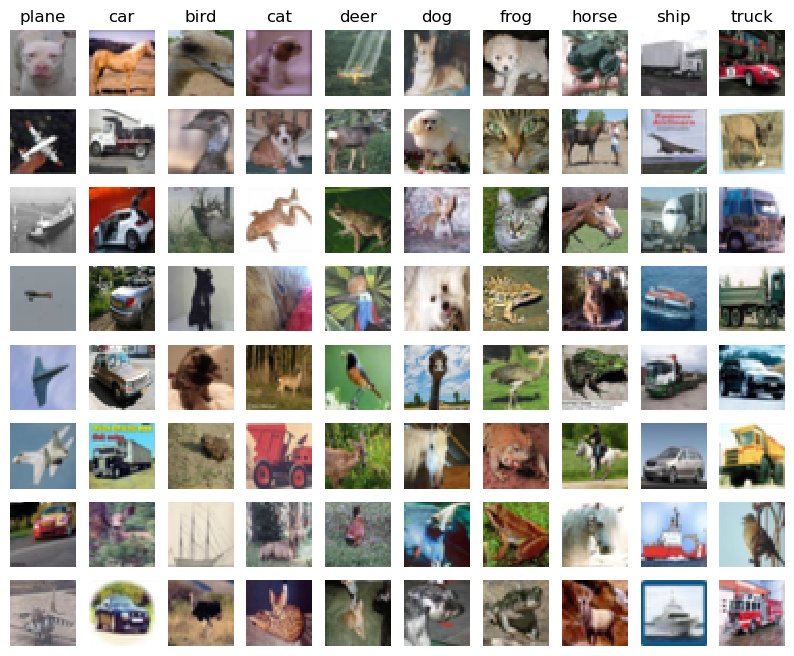

In [31]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    # idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.where(y_test_pred == cls)[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?


$\color{blue}{\textit Your Answer:}$





## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels.

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [32]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 170)
(49000, 169)


In [85]:
from cs231n.classifiers.fc_net import TwoLayerNet
from cs231n.solver import Solver

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

data = {
    'X_train': X_train_feats,
    'y_train': y_train,
    'X_val': X_val_feats,
    'y_val': y_val,
    'X_test': X_test_feats,
    'y_test': y_test,
}

# net = TwoLayerNet(input_dim, hidden_dim, num_classes)
# best_net = None
################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
batch_size_lst = [256, 320]
hidden_dim_lst = [128, 200, 256]
num_epochs_lst = [32]
# optim_config_lst = [{"learning_rate": 1e-2}, {"learning_rate": 5e-1}, {"learning_rate": 8e-1}]
optim_config_lst = [{"learning_rate": 5e-1}]
lr_decay_lst = [0.95, 0.9]
#################################################################################
# TODO: Tune hyperparameters using the validation set. Store your best trained  #
# model in best_model.                                                          #
#                                                                               #
# To help debug your network, it may help to use visualizations similar to the  #
# ones we used above; these visualizations will have significant qualitative    #
# differences from the ones we saw above for the poorly tuned network.          #
#                                                                               #
# Tweaking hyperparameters by hand can be fun, but you might find it useful to  #
# write code to sweep through possible combinations of hyperparameters          #
# automatically like we did on thexs previous exercises.                          #
#################################################################################
para_acc_dic = {}
for batch_size in batch_size_lst:
    for hidden_dim in hidden_dim_lst:
        for num_epochs in num_epochs_lst:
            for optim_config in optim_config_lst:
                for lr_decay in lr_decay_lst:
                    model = TwoLayerNet(input_dim, hidden_dim, num_classes, reg=0.001)
                    solver = Solver(model, data, optim_config=optim_config, verbose=False, lr_decay=lr_decay, num_epochs=num_epochs, batch_size=batch_size)
                    solver.train()
                    para_acc_dic[(batch_size, hidden_dim, num_epochs, optim_config["learning_rate"])] = solver.best_val_acc
                    print(f"when batch_size={batch_size}, hidden_dim={hidden_dim}, num_epochs={num_epochs}, lr={optim_config["learning_rate"]}, lr_decay={lr_decay}, acc={solver.best_val_acc}")

when batch_size=256, hidden_dim=128, num_epochs=32, lr=0.5, lr_decay=0.95, acc=0.588
when batch_size=256, hidden_dim=128, num_epochs=32, lr=0.5, lr_decay=0.9, acc=0.608
when batch_size=256, hidden_dim=200, num_epochs=32, lr=0.5, lr_decay=0.95, acc=0.6
when batch_size=256, hidden_dim=200, num_epochs=32, lr=0.5, lr_decay=0.9, acc=0.605
when batch_size=256, hidden_dim=256, num_epochs=32, lr=0.5, lr_decay=0.95, acc=0.617
when batch_size=256, hidden_dim=256, num_epochs=32, lr=0.5, lr_decay=0.9, acc=0.611
when batch_size=320, hidden_dim=128, num_epochs=32, lr=0.5, lr_decay=0.95, acc=0.598
when batch_size=320, hidden_dim=128, num_epochs=32, lr=0.5, lr_decay=0.9, acc=0.598
when batch_size=320, hidden_dim=200, num_epochs=32, lr=0.5, lr_decay=0.95, acc=0.602
when batch_size=320, hidden_dim=200, num_epochs=32, lr=0.5, lr_decay=0.9, acc=0.605
when batch_size=320, hidden_dim=256, num_epochs=32, lr=0.5, lr_decay=0.95, acc=0.605
when batch_size=320, hidden_dim=256, num_epochs=32, lr=0.5, lr_decay=0.9

In [98]:
best_item = max(para_acc_dic.items(), key = lambda x: x[1])
best_acc = best_item[1]
batch_size, hidden_dim, num_epochs, lr = best_item[0]
print(f"best hyperparameters:batch_size={batch_size}, hidden_dim={hidden_dim}, num_epochs={num_epochs}, lr={lr}, best_acc={best_acc}")
best_model = TwoLayerNet(input_dim, hidden_dim, num_classes, reg=0.003)
solver = Solver(best_model, data, optim_config={"learning_rate": lr}, verbose=True, lr_decay=0.9, num_epochs=num_epochs, batch_size=batch_size)
solver.train()

best hyperparameters:batch_size=320, hidden_dim=256, num_epochs=32, lr=0.5, best_acc=0.616
(Iteration 1 / 4896) loss: 2.302664
(Epoch 0 / 32) train acc: 0.106000; val_acc: 0.078000
(Iteration 11 / 4896) loss: 2.301962
(Iteration 21 / 4896) loss: 2.278726
(Iteration 31 / 4896) loss: 2.074826
(Iteration 41 / 4896) loss: 1.793019
(Iteration 51 / 4896) loss: 1.695232
(Iteration 61 / 4896) loss: 1.560311
(Iteration 71 / 4896) loss: 1.594931
(Iteration 81 / 4896) loss: 1.376978
(Iteration 91 / 4896) loss: 1.475447
(Iteration 101 / 4896) loss: 1.389247
(Iteration 111 / 4896) loss: 1.420551
(Iteration 121 / 4896) loss: 1.440983
(Iteration 131 / 4896) loss: 1.439983
(Iteration 141 / 4896) loss: 1.424427
(Iteration 151 / 4896) loss: 1.470741
(Epoch 1 / 32) train acc: 0.538000; val_acc: 0.501000
(Iteration 161 / 4896) loss: 1.447606
(Iteration 171 / 4896) loss: 1.366677
(Iteration 181 / 4896) loss: 1.279792
(Iteration 191 / 4896) loss: 1.363079
(Iteration 201 / 4896) loss: 1.389744
(Iteration 211

In [99]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 58% accuracy. It is also possible to get >60% accuracy
# with careful tuning.

y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
test_acc = (y_test_pred == data['y_test']).mean()
print(test_acc)

0.589


In [ ]:
# Save best model
best_net.save("best_two_layer_net_features.npy")